<a href="https://colab.research.google.com/github/devikrishna6/Capstone-Project/blob/main/Capsule_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Autonomous Warehouse Robot System**





> 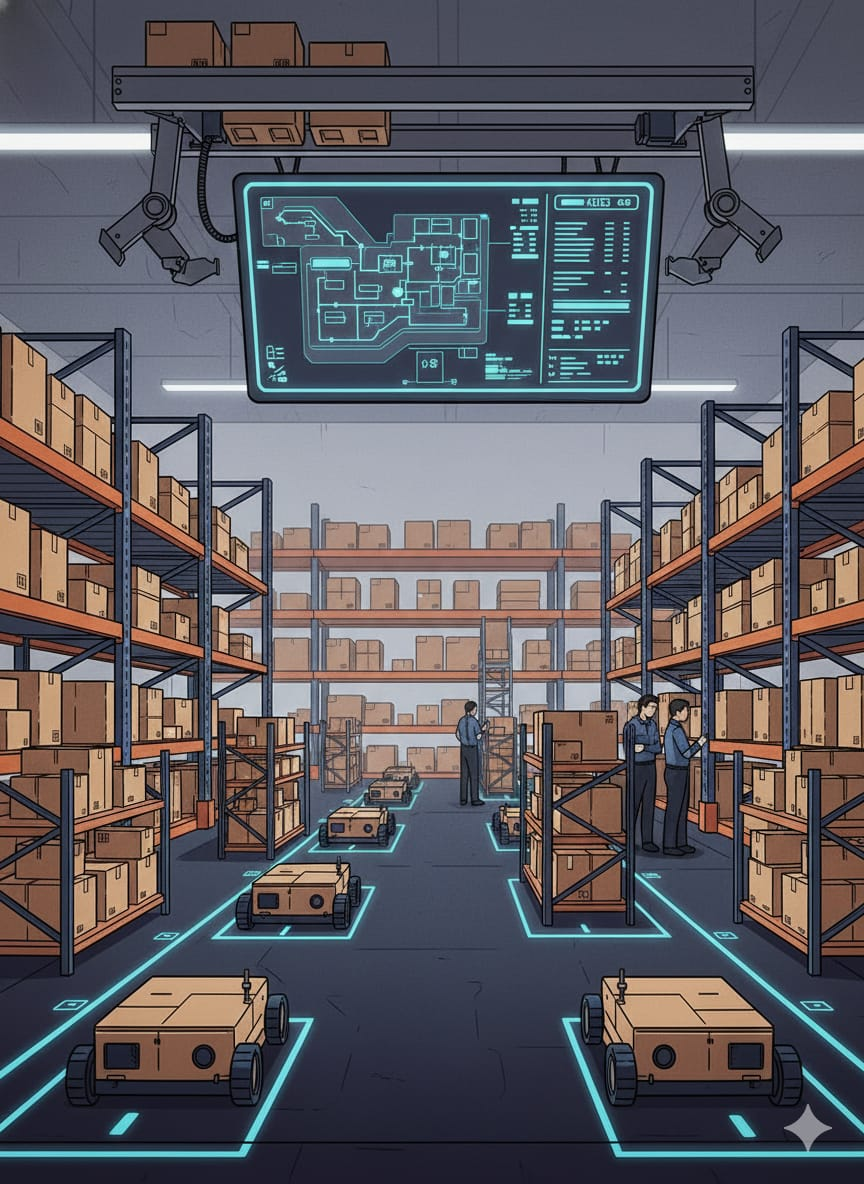



##Project Overview

This project implements an Autonomous Warehouse Robot System using Python in Google Colab. The robot navigates a warehouse grid, avoids obstacles, and moves from a start point to a goal point autonomously. Path planning is done using algorithms like A* or gradient descent, while motion is controlled smoothly using a PID controller. Robot kinematics are modeled using matrix transformations. The system demonstrates the use of linear algebra, optimization, vector calculus, and control theory in a practical robotics application. Visualization is done in 2D or 3D to simulate robot movement and operations.

## Core  Modules

**Module 1 – Environment Setup & Mapping**

In this module, a virtual warehouse environment is created using a grid . Start, goal, and obstacle positions are defined to represent the working area for the robot. Coordinate geometry and matrices are used to represent positions and obstacles in the environment.

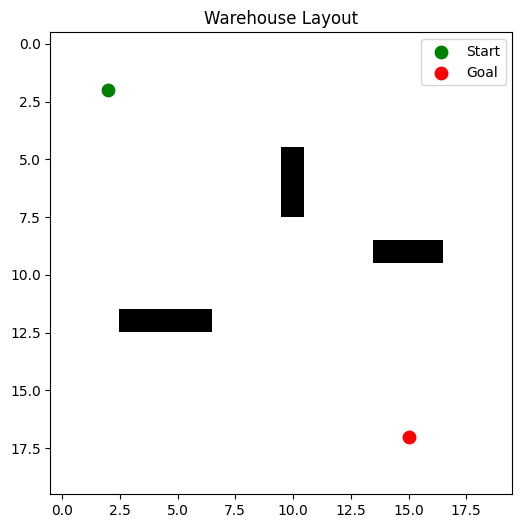

In [ ]:
# Step 1: Warehouse environment setup
import numpy as np
import matplotlib.pyplot as plt

# Create warehouse grid (20x20)
warehouse = np.zeros((20, 20))

# Add obstacles (1 = obstacle)
warehouse[5:8, 10] = 1
warehouse[12, 3:7] = 1
warehouse[9, 14:17] = 1

# Start & Goal positions
start = (2, 2)
goal = (17, 15)

# Plot the map
plt.figure(figsize=(6,6))
plt.imshow(warehouse, cmap='Greys')
plt.scatter(start[1], start[0], color='green', label='Start', s=80)
plt.scatter(goal[1], goal[0], color='red', label='Goal', s=80)
plt.legend()
plt.title("Warehouse Layout")
plt.show()

**Module 2 – Path Planning  **

This module focuses on finding the shortest and obstacle-free path from the start to the goal using the A* algorithm. The algorithm evaluates different routes based on cost functions and heuristics to generate an optimized navigation path. Optimization and heuristics are applied to select the most efficient path using distance formulas and cost calculations.


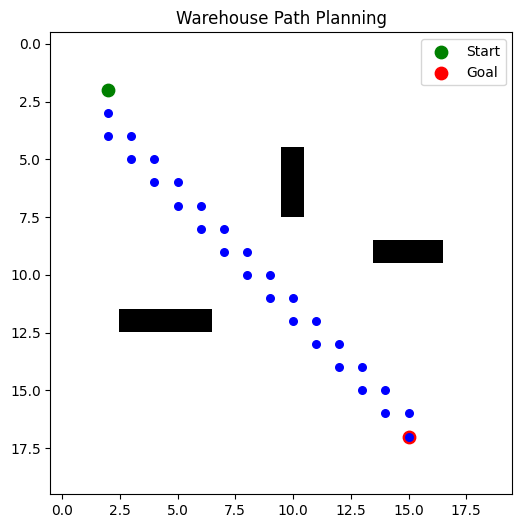

In [ ]:


from heapq import heappush, heappop

# ====== Heuristic function ======
def heuristic(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

# ====== A* Algorithm ======
def astar(array, start, goal):
    neighbors = [(0,1),(1,0),(-1,0),(0,-1)]  # 4 directions
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []
    heappush(oheap, (fscore[start], start))

    while oheap:
        current = heappop(oheap)[1]

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            return path[::-1]

        close_set.add(current)

        for i, j in neighbors:
            neighbor = current[0]+i, current[1]+j
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    continue
            else:
                continue

            tentative_g_score = gscore[current] + 1

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue

            if tentative_g_score < gscore.get(neighbor, float('inf')) or neighbor not in [i[1] for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))

    return False

# ====== Run A* ======
path = astar(warehouse, start, goal)

# ====== Visualize the Path ======
plt.figure(figsize=(6,6))
plt.imshow(warehouse, cmap='Greys')
plt.scatter(start[1], start[0], color='green', label='Start', s=80)
plt.scatter(goal[1], goal[0], color='red', label='Goal', s=80)

if path:
    for point in path:
        plt.scatter(point[1], point[0], color='blue', s=30)  # path points

plt.legend()
plt.title("Warehouse Path Planning")
plt.show()

**Module 3 – Motion Control using PID**

In this module, a PID controller is implemented to control the robot’s speed and direction. It minimizes the error between the actual and desired trajectory, ensuring smooth and accurate movement along the planned path.
 Calculus (differentiation and integration) is used in PID control to compute proportional, integral, and derivative terms for motion correction.


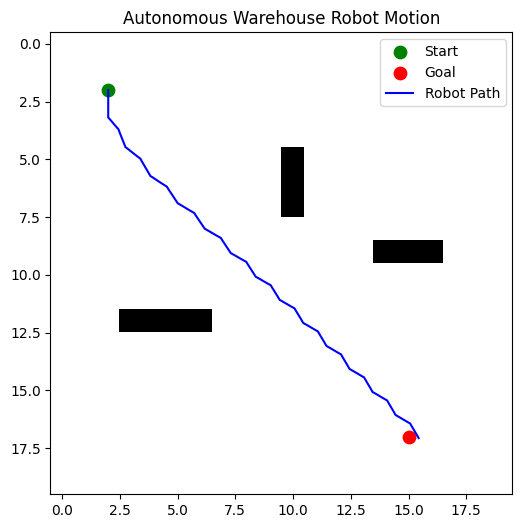

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from heapq import heappush, heappop



# ====== Module 3: PID Motion Control ======
class PID:
    def __init__(self, Kp, Ki, Kd):
        self.Kp, self.Ki, self.Kd = Kp, Ki, Kd
        self.prev_error = 0
        self.integral = 0

    def compute(self, setpoint, actual):
        error = setpoint - actual
        self.integral += error
        derivative = error - self.prev_error
        output = self.Kp*error + self.Ki*self.integral + self.Kd*derivative
        self.prev_error = error
        return output

# PID controllers for X and Y
pid_x = PID(0.5, 0.01, 0.1)
pid_y = PID(0.5, 0.01, 0.1)

# Robot starting position
robot_pos = np.array(start, dtype=float)
robot_path = [robot_pos.copy()]

# Follow the path smoothly
for point in path:
    point = np.array(point, dtype=float)
    for _ in range(10):  # small steps for smoothness
        dx = pid_x.compute(point[0], robot_pos[0])
        dy = pid_y.compute(point[1], robot_pos[1])
        robot_pos[0] += dx * 0.1
        robot_pos[1] += dy * 0.1
        robot_path.append(robot_pos.copy())

robot_path = np.array(robot_path)

# ====== Visualization ======
plt.figure(figsize=(6,6))
plt.imshow(warehouse, cmap='Greys')
plt.scatter(start[1], start[0], color='green', label='Start', s=80)
plt.scatter(goal[1], goal[0], color='red', label='Goal', s=80)
plt.plot(robot_path[:,1], robot_path[:,0], color='blue', label='Robot Path')
plt.legend()
plt.title("Autonomous Warehouse Robot Motion")
plt.show()


**Module 4 – Kinematic Transformations and Simulation**

This module applies transformation matrices to calculate the robot’s motion and orientation based on wheel rotations. The complete system is simulated in Python to visualize the robot’s real-time movement in a 3D warehouse environment. Linear algebra and matrix transformations are used to compute positions, orientations, and rotations of the robot.


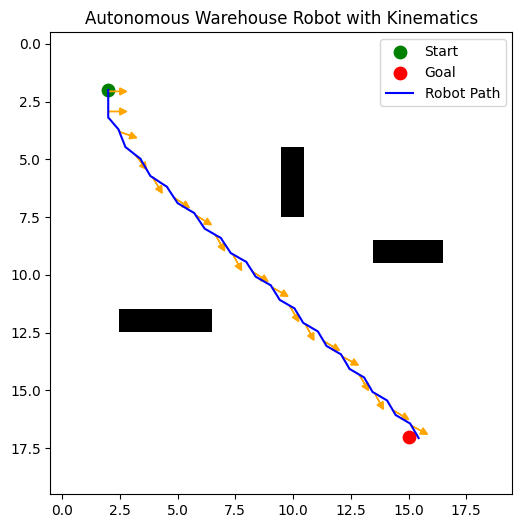

In [ ]:


# ====== Module 4: Robot Kinematics (Orientation/Pose) ======
def transformation_matrix(x, y, theta):
    """
    Returns 3x3 homogeneous transformation matrix for position (x,y) and rotation theta (rad)
    """
    T = np.array([
        [np.cos(theta), -np.sin(theta), x],
        [np.sin(theta), np.cos(theta), y],
        [0, 0, 1]
    ])
    return T

# Compute robot orientation along path
orientations = []
for i in range(1, len(robot_path)):
    dx = robot_path[i][0] - robot_path[i-1][0]
    dy = robot_path[i][1] - robot_path[i-1][1]
    theta = np.arctan2(dy, dx)
    T = transformation_matrix(robot_path[i][1], robot_path[i][0], theta)
    orientations.append(T)

# ====== Visualization ======
plt.figure(figsize=(6,6))
plt.imshow(warehouse, cmap='Greys')
plt.scatter(start[1], start[0], color='green', label='Start', s=80)
plt.scatter(goal[1], goal[0], color='red', label='Goal', s=80)
plt.plot(robot_path[:,1], robot_path[:,0], color='blue', label='Robot Path')

#  show robot orientation every N steps
for i, T in enumerate(orientations[::15]):
    plt.arrow(T[0,2], T[1,2], 0.5*np.cos(np.arctan2(T[1,0], T[0,0])), 0.5*np.sin(np.arctan2(T[1,0], T[0,0])),
              head_width=0.3, head_length=0.3, color='orange')

plt.legend()
plt.title("Autonomous Warehouse Robot with Kinematics")
plt.show()

**Module 5 – Result Visualization & Analysis**

In this module, the results from Modules 1–4 are visualized using Python’s Matplotlib library. Paths, trajectories, and PID-controlled movements are plotted to analyze performance, verify correctness, and evaluate optimization. This module applies mathematical concepts like vectors, matrices, and optimization to interpret and present the robot’s motion data effectively.

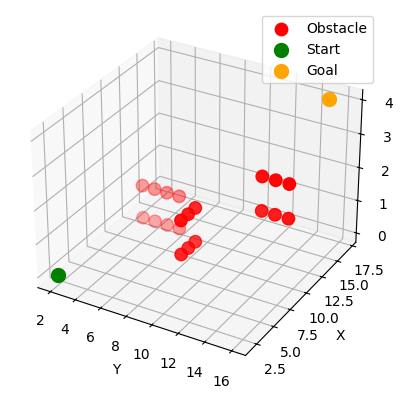

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Warehouse size (X, Y, Z)
warehouse = np.zeros((20, 20, 5))  # 5 layers in Z

# Add obstacles (3D blocks)
warehouse[5:8, 10, 1:3] = 1   # vertical block
warehouse[12, 3:7, 0:2] = 1
warehouse[9, 14:17, 2:4] = 1

# Start & Goal positions (x, y, z)
start = (2, 2, 0)
goal = (17, 15, 4)

# Plot 3D warehouse
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot obstacles
ox, oy, oz = np.where(warehouse == 1)
ax.scatter(oy, ox, oz, c='red', s=80, label='Obstacle')

# Plot start and goal
ax.scatter(start[1], start[0], start[2], color='green', s=100, label='Start')
ax.scatter(goal[1], goal[0], goal[2], color='orange', s=100, label='Goal')

ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_zlabel('Z')
ax.legend()
plt.show()

In [ ]:
import numpy as np
from heapq import heappush, heappop

# Warehouse size and obstacles (same as Step 1)
warehouse = np.zeros((20, 20, 5))
warehouse[5:8, 10, 1:3] = 1
warehouse[12, 3:7, 0:2] = 1
warehouse[9, 14:17, 2:4] = 1

# Start & Goal
start = (2, 2, 0)
goal = (17, 15, 4)

# 3D A* Algorithm
def heuristic(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

def astar_3d(array, start, goal):
    neighbors = [(1,0,0), (-1,0,0), (0,1,0), (0,-1,0), (0,0,1), (0,0,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []
    heappush(oheap, (fscore[start], start))

    while oheap:
        current = heappop(oheap)[1]
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]

        close_set.add(current)

        for dx,dy,dz in neighbors:
            neighbor = current[0]+dx, current[1]+dy, current[2]+dz
            if 0 <= neighbor[0] < array.shape[0] and 0 <= neighbor[1] < array.shape[1] and 0 <= neighbor[2] < array.shape[2]:
                if array[neighbor[0], neighbor[1], neighbor[2]] == 1:
                    continue
            else:
                continue

            tentative_g = gscore[current] + 1
            if neighbor in close_set and tentative_g >= gscore.get(neighbor,0):
                continue
            if tentative_g < gscore.get(neighbor,float('inf')) or neighbor not in [i[1] for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g
                fscore[neighbor] = tentative_g + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))

    return False

# Compute path
path_3d = astar_3d(warehouse, start, goal)
print("3D Path length:", len(path_3d))

3D Path length: 33


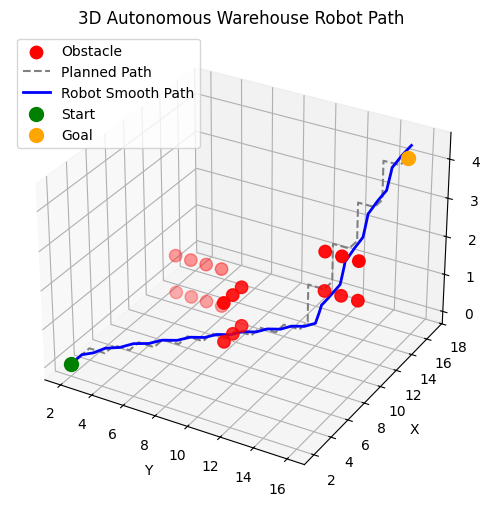

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Use the path from previous step (path_3d)
path_3d = np.array(path_3d)

# ===== 3D PID Controller =====
class PID:
    def __init__(self, Kp, Ki, Kd):
        self.Kp, self.Ki, self.Kd = Kp, Ki, Kd
        self.prev_error = 0
        self.integral = 0
    def compute(self, setpoint, actual):
        error = setpoint - actual
        self.integral += error
        derivative = error - self.prev_error
        output = self.Kp*error + self.Ki*self.integral + self.Kd*derivative
        self.prev_error = error
        return output

# Initialize PID for x, y, z
pid_x = PID(0.5, 0.01, 0.1)
pid_y = PID(0.5, 0.01, 0.1)
pid_z = PID(0.5, 0.01, 0.1)

# Robot initial position
robot_pos = path_3d[0].astype(float)
robot_path_smooth = [robot_pos.copy()]

# Follow path smoothly
for point in path_3d[1:]:
    point = point.astype(float)
    for _ in range(10):  # fine steps
        dx = pid_x.compute(point[0], robot_pos[0])
        dy = pid_y.compute(point[1], robot_pos[1])
        dz = pid_z.compute(point[2], robot_pos[2])
        robot_pos[0] += dx * 0.1
        robot_pos[1] += dy * 0.1
        robot_pos[2] += dz * 0.1
        robot_path_smooth.append(robot_pos.copy())

robot_path_smooth = np.array(robot_path_smooth)

# ===== 3D Visualization =====
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Plot obstacles
ox, oy, oz = np.where(warehouse == 1)
ax.scatter(oy, ox, oz, c='red', s=80, label='Obstacle')

# Plot original path (optional)
ax.plot(path_3d[:,1], path_3d[:,0], path_3d[:,2], c='gray', linestyle='--', label='Planned Path')

# Plot smooth robot path
ax.plot(robot_path_smooth[:,1], robot_path_smooth[:,0], robot_path_smooth[:,2], c='blue', linewidth=2, label='Robot Smooth Path')

# Start & goal
ax.scatter(path_3d[0,1], path_3d[0,0], path_3d[0,2], c='green', s=100, label='Start')
ax.scatter(path_3d[-1,1], path_3d[-1,0], path_3d[-1,2], c='orange', s=100, label='Goal')

ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_zlabel('Z')
ax.legend()
plt.title("3D Autonomous Warehouse Robot Path")
plt.show()

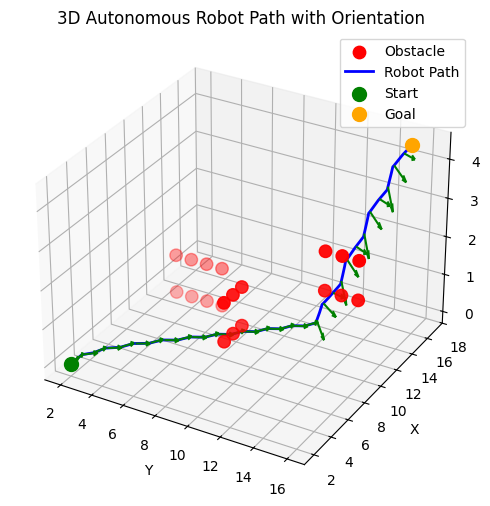

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Use smooth path from Step 3
robot_path = robot_path_smooth

# Function to compute 4x4 transformation matrix for 3D pose
def transformation_matrix_3d(x, y, z, yaw, pitch, roll):
    # Rotation matrices
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(roll), -np.sin(roll)],
                    [0, np.sin(roll), np.cos(roll)]])

    R_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                    [0, 1, 0],
                    [-np.sin(pitch), 0, np.cos(pitch)]])

    R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                    [np.sin(yaw), np.cos(yaw), 0],
                    [0, 0, 1]])

    R = R_z @ R_y @ R_x  # Combined rotation
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = [x, y, z]
    return T

# Compute orientations along the path
orientations = []
for i in range(1, len(robot_path)):
    dx = robot_path[i][0] - robot_path[i-1][0]
    dy = robot_path[i][1] - robot_path[i-1][1]
    dz = robot_path[i][2] - robot_path[i-1][2]
    yaw = np.arctan2(dy, dx)
    pitch = np.arctan2(dz, np.sqrt(dx**2 + dy**2))
    roll = 0
    T = transformation_matrix_3d(robot_path[i,0], robot_path[i,1], robot_path[i,2], yaw, pitch, roll)
    orientations.append(T)

# 3D Plot with robot headings
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Plot obstacles
ox, oy, oz = np.where(warehouse==1)
ax.scatter(oy, ox, oz, c='red', s=80, label='Obstacle')

# Plot smooth path
ax.plot(robot_path[:,1], robot_path[:,0], robot_path[:,2], c='blue', linewidth=2, label='Robot Path')

# Plot orientation arrows every N steps
for T in orientations[::10]:
    x, y, z = T[0,3], T[1,3], T[2,3]
    # Heading direction (x-axis of robot)
    dx, dy, dz = T[:3,0]
    ax.quiver(y, x, z, dy, dx, dz, length=0.8, color='green', linewidth=1.5)

# Start & Goal
ax.scatter(robot_path[0,1], robot_path[0,0], robot_path[0,2], c='green', s=100, label='Start')
ax.scatter(robot_path[-1,1], robot_path[-1,0], robot_path[-1,2], c='orange', s=100, label='Goal')

ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_zlabel('Z')
ax.legend()
plt.title("3D Autonomous Robot Path with Orientation")
plt.show()

##Conclusion

The project successfully demonstrated an Autonomous Warehouse Robot System that navigates efficiently using A* path planning, PID motion control, and kinematic transformations. Python-based simulations validated smooth trajectory tracking, obstacle avoidance, and accurate robot orientation. The study highlights how mathematical concepts like vector calculus, optimization, and linear algebra can be applied to design, control, and visualize real-world robotic systems effectively.